In [1]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
#EXTRACTING BTC FROM BINANCE
exch = 'binance' # initial exchange
t_frame = '1d' # 1-day timeframe, usually from 1-minute to 1-week depending on the exchange
symbol = 'ADA/BTC' # initial symbol
#figure out coinbase, , 'bitstamp', 'bitflyer', 'gemini', 'itbit', 'bittrex'
exchange_list = ['binance','bitfinex','kraken','poloniex']
 
# Get our Exchange
try:
    exchange = getattr (ccxt, exch) ()
except AttributeError:
    print('-'*36,' ERROR ','-'*35)
    print('Exchange "{}" not found. Please check the exchange is supported.'.format(exch))
    print('-'*80)
    quit()
 
# Check if fetching of OHLC Data is supported
if exchange.has["fetchOHLCV"] != True:
    print('-'*36,' ERROR ','-'*35)
    print('{} does not support fetching OHLC data. Please use another  exchange'.format(exch))
    print('-'*80)
    quit()
 
# Check requested timeframe is available. If not return a helpful error.
if (not hasattr(exchange, 'timeframes')) or (t_frame not in exchange.timeframes):
    print('-'*36,' ERROR ','-'*35)
    print('The requested timeframe ({}) is not available from {}\n'.format(t_frame,exch))
    print('Available timeframes are:')
    for key in exchange.timeframes.keys():
        print('  - ' + key)
    print('-'*80)
    quit()
 
# Check if the symbol is available on the Exchange
exchange.load_markets()
if symbol not in exchange.symbols:
    print('-'*36,' ERROR ','-'*35)
    print('The requested symbol ({}) is not available from {}\n'.format(symbol,exch))
    print('Available symbols are:')
    for key in exchange.symbols:
        print('  - ' + key)
    print('-'*80)
    quit()
 
 


In [3]:
#MORE DATA EXTRACTION
# Get data
data = exchange.fetch_ohlcv(symbol, t_frame)
header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
df = pd.DataFrame(data, columns=header).set_index('Timestamp')
df['symbol'] = symbol
syms = [symbol]
filename = '{}.csv'.format(t_frame)
exchange_map = defaultdict(list)
for exch in exchange_list:
    try:
        exchange = getattr (ccxt, exch) ()
    except AttributeError:
        print('-'*36,' ERROR ','-'*35)
        print('Exchange "{}" not found. Please check the exchange is supported.'.format(exch))
        print('-'*80)
        quit()
    if exchange.has["fetchOHLCV"] != True:
        print('-'*36,' ERROR ','-'*35)
        print('{} does not support fetching OHLC data. Please use another exchange'.format(exch))
        print('-'*80)
        quit()
    if (not hasattr(exchange, 'timeframes')) or (t_frame not in exchange.timeframes):
        print('-'*36,' ERROR ','-'*35)
        print('The requested timeframe ({}) is not available from {}\n'.format(t_frame,exch))
        print('Available timeframes are:')
        for key in exchange.timeframes.keys():
            print('  - ' + key)
        print('-'*80)
        quit()
    exchange.load_markets()
    for coin in exchange.symbols:
        if coin in syms or coin[-3:] != 'BTC':
            continue
        else:
            try:
                data = exchange.fetch_ohlcv(coin, t_frame)
            except:
                continue
            data_df = pd.DataFrame(data, columns=header).set_index('Timestamp')
            data_df['symbol'] = coin
            df = df.append(data_df)
            syms.append(coin)
            exchange_map[exch] = [pd.to_datetime(data_df.index/1000, unit='s'), data_df.Close]
df.index = df.index/1000 #Timestamp is 1000 times bigger than it should be in this case
df['Date'] = pd.to_datetime(df.index,unit='s')

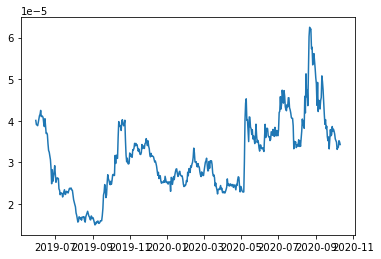

In [4]:
#BINANCE BTC PLOT
plt.plot(exchange_map["binance"][0], exchange_map["binance"][1])

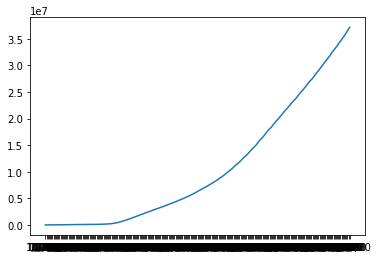

In [12]:
#GLOBAL CONFIRMED COVID CASES PLOT
global_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
gc_df = pd.read_csv(global_cases_url, error_bad_lines=False)
plt.plot(gc_df.iloc[0:, 4:].sum(axis=0))

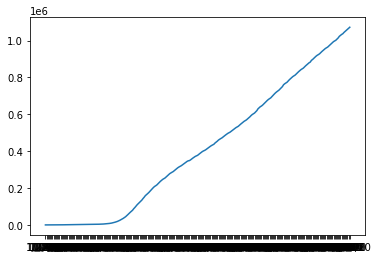

In [14]:
#GLOBAL CONFIRMED COVID DEATHS PLOT
global_deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
gd_df = pd.read_csv(global_deaths_url, error_bad_lines=False)
plt.plot(gd_df.iloc[0:, 4:].sum(axis=0))

In [7]:
#DATASET OF BTC AND COVID CASES FROM 1/22 TO YESTERDAY
confirmed_cases = gc_df.iloc[0:, 4:].sum(axis=0).shift(1)
print(confirmed_cases)
confirmed_cases[0] = 0
binance = exchange_map["binance"][1].iloc[236:-1]
print(len(binance))
dataset = pd.DataFrame({'Binance': binance, 'COVID': confirmed_cases})

1/22/20            NaN
1/23/20          555.0
1/24/20          654.0
1/25/20          941.0
1/26/20         1434.0
               ...    
10/6/20     35479051.0
10/7/20     35806972.0
10/8/20     36156226.0
10/9/20     36515563.0
10/10/20    36876248.0
Length: 263, dtype: float64
263


In [8]:
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [45]:
#RNN FOR COVID CASES AS PREDICTOR FOR BTC PRICE
# scaler = MinMaxScaler(feature_range=(0, 1))
# # dataset = scaler.fit_transform(dataset)
# # print(dataset)
# # split into train and test sets
# datapoints = len(binance)
# train_size = int(datapoints*0.75)
# test_size = datapoints-train_size
# print(train_size)
# print(test_size)

# train = [dataset.Binance[:train_size].values, dataset.COVID[datapoints:datapoints+train_size].values]
# test = [dataset.Binance[train_size:datapoints].values, dataset.COVID[datapoints+train_size:].values]
# scaler.fit_transform(train)
# scaler.fit_transform(test)

# trainX, trainY = train[0], train[1]
# testX, testY = test[0], test[1]

# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, 1))
# testX = np.reshape(testX, (testX.shape[0], 1, 1))
# # create and fit the LSTM network


197
66


In [46]:
#RNN FOR DOW JONES INDEX CASES AS PREDICTOR FOR BTC PRICE
import yfinance as yf
import time
from datetime import date, timedelta

In [47]:
dji = yf.Ticker("^GSPC")
# dji.info
dow = dji.history(interval="1d", start="2020-01-22", end=date.today() - timedelta(days=1)).Close

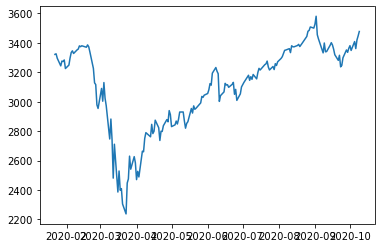

In [48]:
#PLOT OF DJI
plt.plot(dow)

In [83]:
#FILL MISSING DAILY VALUES WITH PREVIOUS DAY'S VAL
date_index = pd.date_range('1/22/2020', periods=datapoints, freq='D')
dow = dow.reindex(index=date_index)
for idx in range(len(dow)):
    if np.isnan(dow[idx]):
        dow[idx] = dow[idx-1]
    print(dow[idx])
# print(dow[0:5].values)

3321.75
3325.5400390625
3295.469970703125
3295.469970703125
3295.469970703125
3243.6298828125
3276.239990234375
3273.39990234375
3283.659912109375
3225.52001953125
3225.52001953125
3225.52001953125
3248.919921875
3297.590087890625
3334.68994140625
3345.780029296875
3327.7099609375
3327.7099609375
3327.7099609375
3352.090087890625
3357.75
3379.449951171875
3373.93994140625
3380.159912109375
3380.159912109375
3380.159912109375
3380.159912109375
3370.2900390625
3386.14990234375
3373.22998046875
3337.75
3337.75
3337.75
3225.889892578125
3128.2099609375
3116.389892578125
2978.760009765625
2954.219970703125
2954.219970703125
2954.219970703125
3090.22998046875
3003.3701171875
3130.1201171875
3023.93994140625
2972.3701171875
2972.3701171875
2972.3701171875
2746.56005859375
2882.22998046875
2741.3798828125
2480.639892578125
2711.02001953125
2711.02001953125
2711.02001953125
2386.1298828125
2529.18994140625
2398.10009765625
2409.389892578125
2304.919921875
2304.919921875
2304.919921875
2237.3999

In [84]:
#RNN PREPROCESSING
scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)
# print(dataset)
# split into train and test sets
datapoints = len(binance)
train_size = int(datapoints*0.75)
test_size = datapoints-train_size


train = [dataset.Binance[:train_size].values, dow[:train_size].values]
test = [dataset.Binance[train_size:datapoints].values, dow[train_size:].values]
# scaler.fit_transform(train)
# scaler.fit_transform(test)

trainX, trainY = train[0], train[1]
testX, testY = test[0], test[1]
print(testY)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, 1))
testX = np.reshape(testX, (testX.shape[0], 1, 1))
# create and fit the LSTM network


[3349.15991211 3351.2800293  3351.2800293  3351.2800293  3360.4699707
 3333.68994141 3380.35009766 3373.42993164 3372.85009766 3372.85009766
 3372.85009766 3381.98999023 3389.7800293  3374.85009766 3385.51000977
 3397.15991211 3397.15991211 3397.15991211 3431.2800293  3443.62011719
 3478.72998047 3484.55004883 3508.01000977 3508.01000977 3508.01000977
 3500.31005859 3526.64990234 3580.84008789 3455.06005859 3426.95996094
 3426.95996094 3426.95996094 3426.95996094 3331.84008789 3398.95996094
 3339.18994141 3340.9699707  3340.9699707  3340.9699707  3383.54003906
 3401.19995117 3385.48999023 3357.01000977 3319.4699707  3319.4699707
 3319.4699707  3281.06005859 3315.57006836 3236.91992188 3246.59008789
 3298.45996094 3298.45996094 3298.45996094 3351.60009766 3335.4699707
 3363.         3380.80004883 3348.41992188 3348.41992188 3348.41992188
 3408.60009766 3360.9699707  3419.43994141 3446.83007812 3477.13989258
 3477.13989258]


In [98]:
#RNN ARCHITECTURE
model = keras.Sequential()


model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(units=2))
model.add(Activation('relu'))

model.compile(loss='mae', optimizer='adam')
# # fit network
model.fit(trainX, trainY, epochs=2111, batch_size=72, validation_data=(testX, testY), verbose=2, shuffle=False)
# plot history


Epoch 1/2111
3/3 - 0s - loss: 3007.0044 - val_loss: 3385.5303
Epoch 2/2111
3/3 - 0s - loss: 3006.9861 - val_loss: 3385.5154
Epoch 3/2111
3/3 - 0s - loss: 3006.9668 - val_loss: 3385.4954
Epoch 4/2111
3/3 - 0s - loss: 3006.9473 - val_loss: 3385.4702
Epoch 5/2111
3/3 - 0s - loss: 3006.9260 - val_loss: 3385.4526
Epoch 6/2111
3/3 - 0s - loss: 3006.9036 - val_loss: 3385.4297
Epoch 7/2111
3/3 - 0s - loss: 3006.8801 - val_loss: 3385.4006
Epoch 8/2111
3/3 - 0s - loss: 3006.8552 - val_loss: 3385.3792
Epoch 9/2111
3/3 - 0s - loss: 3006.8291 - val_loss: 3385.3481
Epoch 10/2111
3/3 - 0s - loss: 3006.8015 - val_loss: 3385.3223
Epoch 11/2111
3/3 - 0s - loss: 3006.7715 - val_loss: 3385.2878
Epoch 12/2111
3/3 - 0s - loss: 3006.7407 - val_loss: 3385.2595
Epoch 13/2111
3/3 - 0s - loss: 3006.7080 - val_loss: 3385.2212
Epoch 14/2111
3/3 - 0s - loss: 3006.6733 - val_loss: 3385.1904
Epoch 15/2111
3/3 - 0s - loss: 3006.6370 - val_loss: 3385.1494
Epoch 16/2111
3/3 - 0s - loss: 3006.5996 - val_loss: 3385.1096
E

Epoch 131/2111
3/3 - 0s - loss: 2986.7847 - val_loss: 3365.1067
Epoch 132/2111
3/3 - 0s - loss: 2986.4746 - val_loss: 3364.7966
Epoch 133/2111
3/3 - 0s - loss: 2986.1628 - val_loss: 3364.4817
Epoch 134/2111
3/3 - 0s - loss: 2985.8484 - val_loss: 3364.1641
Epoch 135/2111
3/3 - 0s - loss: 2985.5320 - val_loss: 3363.8481
Epoch 136/2111
3/3 - 0s - loss: 2985.2129 - val_loss: 3363.5276
Epoch 137/2111
3/3 - 0s - loss: 2984.8921 - val_loss: 3363.2058
Epoch 138/2111
3/3 - 0s - loss: 2984.5688 - val_loss: 3362.8833
Epoch 139/2111
3/3 - 0s - loss: 2984.2429 - val_loss: 3362.5559
Epoch 140/2111
3/3 - 0s - loss: 2983.9150 - val_loss: 3362.2219
Epoch 141/2111
3/3 - 0s - loss: 2983.5845 - val_loss: 3361.8933
Epoch 142/2111
3/3 - 0s - loss: 2983.2522 - val_loss: 3361.5591
Epoch 143/2111
3/3 - 0s - loss: 2982.9170 - val_loss: 3361.2197
Epoch 144/2111
3/3 - 0s - loss: 2982.5796 - val_loss: 3360.8848
Epoch 145/2111
3/3 - 0s - loss: 2982.2405 - val_loss: 3360.5391
Epoch 146/2111
3/3 - 0s - loss: 2981.898

3/3 - 0s - loss: 2929.2610 - val_loss: 3307.3975
Epoch 260/2111
3/3 - 0s - loss: 2928.6765 - val_loss: 3306.8145
Epoch 261/2111
3/3 - 0s - loss: 2928.0898 - val_loss: 3306.2207
Epoch 262/2111
3/3 - 0s - loss: 2927.5007 - val_loss: 3305.6348
Epoch 263/2111
3/3 - 0s - loss: 2926.9099 - val_loss: 3305.0381
Epoch 264/2111
3/3 - 0s - loss: 2926.3169 - val_loss: 3304.4473
Epoch 265/2111
3/3 - 0s - loss: 2925.7222 - val_loss: 3303.8484
Epoch 266/2111
3/3 - 0s - loss: 2925.1257 - val_loss: 3303.2529
Epoch 267/2111
3/3 - 0s - loss: 2924.5266 - val_loss: 3302.6494
Epoch 268/2111
3/3 - 0s - loss: 2923.9260 - val_loss: 3302.0471
Epoch 269/2111
3/3 - 0s - loss: 2923.3235 - val_loss: 3301.4458
Epoch 270/2111
3/3 - 0s - loss: 2922.7180 - val_loss: 3300.8364
Epoch 271/2111
3/3 - 0s - loss: 2922.1111 - val_loss: 3300.2261
Epoch 272/2111
3/3 - 0s - loss: 2921.5029 - val_loss: 3299.6196
Epoch 273/2111
3/3 - 0s - loss: 2920.8918 - val_loss: 3299.0085
Epoch 274/2111
3/3 - 0s - loss: 2920.2798 - val_loss: 3

Epoch 388/2111
3/3 - 0s - loss: 2837.9810 - val_loss: 3215.9473
Epoch 389/2111
3/3 - 0s - loss: 2837.1538 - val_loss: 3215.1191
Epoch 390/2111
3/3 - 0s - loss: 2836.3252 - val_loss: 3214.2859
Epoch 391/2111
3/3 - 0s - loss: 2835.4949 - val_loss: 3213.4558
Epoch 392/2111
3/3 - 0s - loss: 2834.6628 - val_loss: 3212.6213
Epoch 393/2111
3/3 - 0s - loss: 2833.8281 - val_loss: 3211.7808
Epoch 394/2111
3/3 - 0s - loss: 2832.9924 - val_loss: 3210.9497
Epoch 395/2111
3/3 - 0s - loss: 2832.1545 - val_loss: 3210.1096
Epoch 396/2111
3/3 - 0s - loss: 2831.3154 - val_loss: 3209.2698
Epoch 397/2111
3/3 - 0s - loss: 2830.4744 - val_loss: 3208.4299
Epoch 398/2111
3/3 - 0s - loss: 2829.6313 - val_loss: 3207.5847
Epoch 399/2111
3/3 - 0s - loss: 2828.7869 - val_loss: 3206.7415
Epoch 400/2111
3/3 - 0s - loss: 2827.9404 - val_loss: 3205.8911
Epoch 401/2111
3/3 - 0s - loss: 2827.0925 - val_loss: 3205.0391
Epoch 402/2111
3/3 - 0s - loss: 2826.2429 - val_loss: 3204.1929
Epoch 403/2111
3/3 - 0s - loss: 2825.390

3/3 - 0s - loss: 2718.3264 - val_loss: 3096.1377
Epoch 517/2111
3/3 - 0s - loss: 2717.2861 - val_loss: 3095.0894
Epoch 518/2111
3/3 - 0s - loss: 2716.2439 - val_loss: 3094.0466
Epoch 519/2111
3/3 - 0s - loss: 2715.2004 - val_loss: 3093.0024
Epoch 520/2111
3/3 - 0s - loss: 2714.1558 - val_loss: 3091.9536
Epoch 521/2111
3/3 - 0s - loss: 2713.1089 - val_loss: 3090.9033
Epoch 522/2111
3/3 - 0s - loss: 2712.0605 - val_loss: 3089.8552
Epoch 523/2111
3/3 - 0s - loss: 2711.0110 - val_loss: 3088.8069
Epoch 524/2111
3/3 - 0s - loss: 2709.9595 - val_loss: 3087.7556
Epoch 525/2111
3/3 - 0s - loss: 2708.9070 - val_loss: 3086.7034
Epoch 526/2111
3/3 - 0s - loss: 2707.8521 - val_loss: 3085.6455
Epoch 527/2111
3/3 - 0s - loss: 2706.7966 - val_loss: 3084.5872
Epoch 528/2111
3/3 - 0s - loss: 2705.7385 - val_loss: 3083.5281
Epoch 529/2111
3/3 - 0s - loss: 2704.6797 - val_loss: 3082.4700
Epoch 530/2111
3/3 - 0s - loss: 2703.6194 - val_loss: 3081.4075
Epoch 531/2111
3/3 - 0s - loss: 2702.5569 - val_loss: 3

Epoch 645/2111
3/3 - 0s - loss: 2571.5115 - val_loss: 2949.1973
Epoch 646/2111
3/3 - 0s - loss: 2570.2769 - val_loss: 2947.9573
Epoch 647/2111
3/3 - 0s - loss: 2569.0415 - val_loss: 2946.7158
Epoch 648/2111
3/3 - 0s - loss: 2567.8042 - val_loss: 2945.4749
Epoch 649/2111
3/3 - 0s - loss: 2566.5654 - val_loss: 2944.2344
Epoch 650/2111
3/3 - 0s - loss: 2565.3252 - val_loss: 2942.9939
Epoch 651/2111
3/3 - 0s - loss: 2564.0837 - val_loss: 2941.7512
Epoch 652/2111
3/3 - 0s - loss: 2562.8411 - val_loss: 2940.5073
Epoch 653/2111
3/3 - 0s - loss: 2561.5964 - val_loss: 2939.2625
Epoch 654/2111
3/3 - 0s - loss: 2560.3508 - val_loss: 2938.0132
Epoch 655/2111
3/3 - 0s - loss: 2559.1035 - val_loss: 2936.7656
Epoch 656/2111
3/3 - 0s - loss: 2557.8550 - val_loss: 2935.5134
Epoch 657/2111
3/3 - 0s - loss: 2556.6047 - val_loss: 2934.2588
Epoch 658/2111
3/3 - 0s - loss: 2555.3535 - val_loss: 2933.0042
Epoch 659/2111
3/3 - 0s - loss: 2554.1001 - val_loss: 2931.7463
Epoch 660/2111
3/3 - 0s - loss: 2552.845

3/3 - 0s - loss: 2402.1460 - val_loss: 2779.6907
Epoch 774/2111
3/3 - 0s - loss: 2400.7354 - val_loss: 2778.2744
Epoch 775/2111
3/3 - 0s - loss: 2399.3230 - val_loss: 2776.8586
Epoch 776/2111
3/3 - 0s - loss: 2397.9087 - val_loss: 2775.4448
Epoch 777/2111
3/3 - 0s - loss: 2396.4941 - val_loss: 2774.0259
Epoch 778/2111
3/3 - 0s - loss: 2395.0776 - val_loss: 2772.6133
Epoch 779/2111
3/3 - 0s - loss: 2393.6597 - val_loss: 2771.1948
Epoch 780/2111
3/3 - 0s - loss: 2392.2405 - val_loss: 2769.7703
Epoch 781/2111
3/3 - 0s - loss: 2390.8203 - val_loss: 2768.3508
Epoch 782/2111
3/3 - 0s - loss: 2389.3987 - val_loss: 2766.9292
Epoch 783/2111
3/3 - 0s - loss: 2387.9756 - val_loss: 2765.5020
Epoch 784/2111
3/3 - 0s - loss: 2386.5515 - val_loss: 2764.0742
Epoch 785/2111
3/3 - 0s - loss: 2385.1257 - val_loss: 2762.6443
Epoch 786/2111
3/3 - 0s - loss: 2383.6985 - val_loss: 2761.2129
Epoch 787/2111
3/3 - 0s - loss: 2382.2703 - val_loss: 2759.7834
Epoch 788/2111
3/3 - 0s - loss: 2380.8411 - val_loss: 2

Epoch 902/2111
3/3 - 0s - loss: 2209.3826 - val_loss: 2586.8552
Epoch 903/2111
3/3 - 0s - loss: 2207.8057 - val_loss: 2585.2751
Epoch 904/2111
3/3 - 0s - loss: 2206.2275 - val_loss: 2583.7026
Epoch 905/2111
3/3 - 0s - loss: 2204.6479 - val_loss: 2582.1218
Epoch 906/2111
3/3 - 0s - loss: 2203.0669 - val_loss: 2580.5388
Epoch 907/2111
3/3 - 0s - loss: 2201.4851 - val_loss: 2578.9556
Epoch 908/2111
3/3 - 0s - loss: 2199.9016 - val_loss: 2577.3696
Epoch 909/2111
3/3 - 0s - loss: 2198.3169 - val_loss: 2575.7798
Epoch 910/2111
3/3 - 0s - loss: 2196.7314 - val_loss: 2574.1936
Epoch 911/2111
3/3 - 0s - loss: 2195.1445 - val_loss: 2572.6055
Epoch 912/2111
3/3 - 0s - loss: 2193.5564 - val_loss: 2571.0195
Epoch 913/2111
3/3 - 0s - loss: 2191.9668 - val_loss: 2569.4326
Epoch 914/2111
3/3 - 0s - loss: 2190.3762 - val_loss: 2567.8440
Epoch 915/2111
3/3 - 0s - loss: 2188.7842 - val_loss: 2566.2546
Epoch 916/2111
3/3 - 0s - loss: 2187.1907 - val_loss: 2564.6628
Epoch 917/2111
3/3 - 0s - loss: 2185.596

Epoch 1030/2111
3/3 - 0s - loss: 1997.5632 - val_loss: 2374.9209
Epoch 1031/2111
3/3 - 0s - loss: 1995.8307 - val_loss: 2373.1868
Epoch 1032/2111
3/3 - 0s - loss: 1994.0968 - val_loss: 2371.4531
Epoch 1033/2111
3/3 - 0s - loss: 1992.3619 - val_loss: 2369.7170
Epoch 1034/2111
3/3 - 0s - loss: 1990.6262 - val_loss: 2367.9817
Epoch 1035/2111
3/3 - 0s - loss: 1988.8887 - val_loss: 2366.2375
Epoch 1036/2111
3/3 - 0s - loss: 1987.1504 - val_loss: 2364.4954
Epoch 1037/2111
3/3 - 0s - loss: 1985.4105 - val_loss: 2362.7546
Epoch 1038/2111
3/3 - 0s - loss: 1983.6699 - val_loss: 2361.0156
Epoch 1039/2111
3/3 - 0s - loss: 1981.9276 - val_loss: 2359.2725
Epoch 1040/2111
3/3 - 0s - loss: 1980.1847 - val_loss: 2357.5281
Epoch 1041/2111
3/3 - 0s - loss: 1978.4403 - val_loss: 2355.7891
Epoch 1042/2111
3/3 - 0s - loss: 1976.6945 - val_loss: 2354.0503
Epoch 1043/2111
3/3 - 0s - loss: 1974.9482 - val_loss: 2352.3054
Epoch 1044/2111
3/3 - 0s - loss: 1973.2002 - val_loss: 2350.5596
Epoch 1045/2111
3/3 - 0s 

3/3 - 0s - loss: 1770.0590 - val_loss: 2147.2258
Epoch 1157/2111
3/3 - 0s - loss: 1768.1802 - val_loss: 2145.3542
Epoch 1158/2111
3/3 - 0s - loss: 1766.2999 - val_loss: 2143.4797
Epoch 1159/2111
3/3 - 0s - loss: 1764.4191 - val_loss: 2141.6018
Epoch 1160/2111
3/3 - 0s - loss: 1762.5370 - val_loss: 2139.7173
Epoch 1161/2111
3/3 - 0s - loss: 1760.6534 - val_loss: 2137.8320
Epoch 1162/2111
3/3 - 0s - loss: 1758.7687 - val_loss: 2135.9473
Epoch 1163/2111
3/3 - 0s - loss: 1756.8833 - val_loss: 2134.0708
Epoch 1164/2111
3/3 - 0s - loss: 1754.9965 - val_loss: 2132.1821
Epoch 1165/2111
3/3 - 0s - loss: 1753.1085 - val_loss: 2130.2981
Epoch 1166/2111
3/3 - 0s - loss: 1751.2194 - val_loss: 2128.4119
Epoch 1167/2111
3/3 - 0s - loss: 1749.3293 - val_loss: 2126.5215
Epoch 1168/2111
3/3 - 0s - loss: 1747.4381 - val_loss: 2124.6345
Epoch 1169/2111
3/3 - 0s - loss: 1745.5455 - val_loss: 2122.7334
Epoch 1170/2111
3/3 - 0s - loss: 1743.6520 - val_loss: 2120.8416
Epoch 1171/2111
3/3 - 0s - loss: 1741.757

Epoch 1283/2111
3/3 - 0s - loss: 1522.4380 - val_loss: 1899.5182
Epoch 1284/2111
3/3 - 0s - loss: 1520.4167 - val_loss: 1897.4890
Epoch 1285/2111
3/3 - 0s - loss: 1518.3947 - val_loss: 1895.4696
Epoch 1286/2111
3/3 - 0s - loss: 1516.3713 - val_loss: 1893.4487
Epoch 1287/2111
3/3 - 0s - loss: 1514.3470 - val_loss: 1891.4221
Epoch 1288/2111
3/3 - 0s - loss: 1512.3215 - val_loss: 1889.3971
Epoch 1289/2111
3/3 - 0s - loss: 1510.2949 - val_loss: 1887.3790
Epoch 1290/2111
3/3 - 0s - loss: 1508.2675 - val_loss: 1885.3540
Epoch 1291/2111
3/3 - 0s - loss: 1506.2383 - val_loss: 1883.3191
Epoch 1292/2111
3/3 - 0s - loss: 1504.2085 - val_loss: 1881.2810
Epoch 1293/2111
3/3 - 0s - loss: 1502.1775 - val_loss: 1879.2386
Epoch 1294/2111
3/3 - 0s - loss: 1500.1453 - val_loss: 1877.2009
Epoch 1295/2111
3/3 - 0s - loss: 1498.1123 - val_loss: 1875.1599
Epoch 1296/2111
3/3 - 0s - loss: 1496.0780 - val_loss: 1873.1196
Epoch 1297/2111
3/3 - 0s - loss: 1494.0427 - val_loss: 1871.0818
Epoch 1298/2111
3/3 - 0s 

3/3 - 0s - loss: 1259.1724 - val_loss: 1635.9827
Epoch 1410/2111
3/3 - 0s - loss: 1257.0139 - val_loss: 1633.8414
Epoch 1411/2111
3/3 - 0s - loss: 1254.8545 - val_loss: 1631.6918
Epoch 1412/2111
3/3 - 0s - loss: 1252.6943 - val_loss: 1629.5449
Epoch 1413/2111
3/3 - 0s - loss: 1250.5330 - val_loss: 1627.3909
Epoch 1414/2111
3/3 - 0s - loss: 1248.3702 - val_loss: 1625.2356
Epoch 1415/2111
3/3 - 0s - loss: 1246.2065 - val_loss: 1623.0935
Epoch 1416/2111
3/3 - 0s - loss: 1244.0420 - val_loss: 1620.9528
Epoch 1417/2111
3/3 - 0s - loss: 1241.8760 - val_loss: 1618.7969
Epoch 1418/2111
3/3 - 0s - loss: 1239.7094 - val_loss: 1616.6327
Epoch 1419/2111
3/3 - 0s - loss: 1237.5414 - val_loss: 1614.4628
Epoch 1420/2111
3/3 - 0s - loss: 1235.3723 - val_loss: 1612.2919
Epoch 1421/2111
3/3 - 0s - loss: 1233.2024 - val_loss: 1610.1152
Epoch 1422/2111
3/3 - 0s - loss: 1231.0311 - val_loss: 1607.9321
Epoch 1423/2111
3/3 - 0s - loss: 1228.8588 - val_loss: 1605.7449
Epoch 1424/2111
3/3 - 0s - loss: 1226.685

Epoch 1536/2111
3/3 - 0s - loss: 976.5270 - val_loss: 1353.5664
Epoch 1537/2111
3/3 - 0s - loss: 974.2334 - val_loss: 1351.2778
Epoch 1538/2111
3/3 - 0s - loss: 971.9388 - val_loss: 1348.9856
Epoch 1539/2111
3/3 - 0s - loss: 969.6434 - val_loss: 1346.6832
Epoch 1540/2111
3/3 - 0s - loss: 967.3467 - val_loss: 1344.3905
Epoch 1541/2111
3/3 - 0s - loss: 965.0490 - val_loss: 1342.1049
Epoch 1542/2111
3/3 - 0s - loss: 962.7502 - val_loss: 1339.8346
Epoch 1543/2111
3/3 - 0s - loss: 960.4505 - val_loss: 1337.5859
Epoch 1544/2111
3/3 - 0s - loss: 958.1495 - val_loss: 1335.3207
Epoch 1545/2111
3/3 - 0s - loss: 955.8478 - val_loss: 1333.0563
Epoch 1546/2111
3/3 - 0s - loss: 953.5448 - val_loss: 1330.7952
Epoch 1547/2111
3/3 - 0s - loss: 951.2409 - val_loss: 1328.4949
Epoch 1548/2111
3/3 - 0s - loss: 948.9357 - val_loss: 1326.1801
Epoch 1549/2111
3/3 - 0s - loss: 946.6296 - val_loss: 1323.8687
Epoch 1550/2111
3/3 - 0s - loss: 944.3225 - val_loss: 1321.5760
Epoch 1551/2111
3/3 - 0s - loss: 942.014

3/3 - 0s - loss: 677.4548 - val_loss: 1053.8103
Epoch 1665/2111
3/3 - 0s - loss: 675.2058 - val_loss: 1051.4307
Epoch 1666/2111
3/3 - 0s - loss: 672.9562 - val_loss: 1049.0514
Epoch 1667/2111
3/3 - 0s - loss: 670.7055 - val_loss: 1046.6721
Epoch 1668/2111
3/3 - 0s - loss: 668.4536 - val_loss: 1044.2931
Epoch 1669/2111
3/3 - 0s - loss: 666.2007 - val_loss: 1041.9132
Epoch 1670/2111
3/3 - 0s - loss: 663.9470 - val_loss: 1039.5338
Epoch 1671/2111
3/3 - 0s - loss: 661.6924 - val_loss: 1037.1542
Epoch 1672/2111
3/3 - 0s - loss: 659.4362 - val_loss: 1034.7733
Epoch 1673/2111
3/3 - 0s - loss: 657.1792 - val_loss: 1032.3928
Epoch 1674/2111
3/3 - 0s - loss: 654.9209 - val_loss: 1030.0116
Epoch 1675/2111
3/3 - 0s - loss: 652.6614 - val_loss: 1027.6304
Epoch 1676/2111
3/3 - 0s - loss: 650.4009 - val_loss: 1025.2482
Epoch 1677/2111
3/3 - 0s - loss: 648.1392 - val_loss: 1022.8658
Epoch 1678/2111
3/3 - 0s - loss: 645.8762 - val_loss: 1020.4832
Epoch 1679/2111
3/3 - 0s - loss: 643.6122 - val_loss: 10

Epoch 1794/2111
3/3 - 0s - loss: 417.7796 - val_loss: 758.8666
Epoch 1795/2111
3/3 - 0s - loss: 416.0642 - val_loss: 756.7091
Epoch 1796/2111
3/3 - 0s - loss: 414.3648 - val_loss: 754.5554
Epoch 1797/2111
3/3 - 0s - loss: 412.6834 - val_loss: 752.4111
Epoch 1798/2111
3/3 - 0s - loss: 411.0205 - val_loss: 750.2728
Epoch 1799/2111
3/3 - 0s - loss: 409.3618 - val_loss: 748.1395
Epoch 1800/2111
3/3 - 0s - loss: 407.7059 - val_loss: 746.0077
Epoch 1801/2111
3/3 - 0s - loss: 406.0515 - val_loss: 743.8779
Epoch 1802/2111
3/3 - 0s - loss: 404.3981 - val_loss: 741.7490
Epoch 1803/2111
3/3 - 0s - loss: 402.7451 - val_loss: 739.6202
Epoch 1804/2111
3/3 - 0s - loss: 401.0918 - val_loss: 737.4904
Epoch 1805/2111
3/3 - 0s - loss: 399.4383 - val_loss: 735.3596
Epoch 1806/2111
3/3 - 0s - loss: 397.7839 - val_loss: 733.2286
Epoch 1807/2111
3/3 - 0s - loss: 396.1285 - val_loss: 731.0964
Epoch 1808/2111
3/3 - 0s - loss: 394.4725 - val_loss: 728.9625
Epoch 1809/2111
3/3 - 0s - loss: 392.8154 - val_loss: 7

3/3 - 0s - loss: 251.3557 - val_loss: 509.0415
Epoch 1925/2111
3/3 - 0s - loss: 250.8354 - val_loss: 507.6852
Epoch 1926/2111
3/3 - 0s - loss: 250.3247 - val_loss: 506.3466
Epoch 1927/2111
3/3 - 0s - loss: 249.8273 - val_loss: 505.0231
Epoch 1928/2111
3/3 - 0s - loss: 249.3419 - val_loss: 503.7153
Epoch 1929/2111
3/3 - 0s - loss: 248.8703 - val_loss: 502.4253
Epoch 1930/2111
3/3 - 0s - loss: 248.4164 - val_loss: 501.1528
Epoch 1931/2111
3/3 - 0s - loss: 247.9730 - val_loss: 499.8931
Epoch 1932/2111
3/3 - 0s - loss: 247.5335 - val_loss: 498.6423
Epoch 1933/2111
3/3 - 0s - loss: 247.0966 - val_loss: 497.3975
Epoch 1934/2111
3/3 - 0s - loss: 246.6615 - val_loss: 496.1572
Epoch 1935/2111
3/3 - 0s - loss: 246.2274 - val_loss: 494.9191
Epoch 1936/2111
3/3 - 0s - loss: 245.7942 - val_loss: 493.6835
Epoch 1937/2111
3/3 - 0s - loss: 245.3614 - val_loss: 492.4483
Epoch 1938/2111
3/3 - 0s - loss: 244.9289 - val_loss: 491.2134
Epoch 1939/2111
3/3 - 0s - loss: 244.4965 - val_loss: 489.9788
Epoch 19

Epoch 2055/2111
3/3 - 0s - loss: 217.9970 - val_loss: 381.7594
Epoch 2056/2111
3/3 - 0s - loss: 217.9254 - val_loss: 381.1176
Epoch 2057/2111
3/3 - 0s - loss: 217.8578 - val_loss: 380.4855
Epoch 2058/2111
3/3 - 0s - loss: 217.7913 - val_loss: 379.8592
Epoch 2059/2111
3/3 - 0s - loss: 217.7252 - val_loss: 379.2384
Epoch 2060/2111
3/3 - 0s - loss: 217.6593 - val_loss: 378.6204
Epoch 2061/2111
3/3 - 0s - loss: 217.5938 - val_loss: 378.0049
Epoch 2062/2111
3/3 - 0s - loss: 217.5283 - val_loss: 377.3911
Epoch 2063/2111
3/3 - 0s - loss: 217.4630 - val_loss: 376.7788
Epoch 2064/2111
3/3 - 0s - loss: 217.4060 - val_loss: 376.1733
Epoch 2065/2111
3/3 - 0s - loss: 217.3561 - val_loss: 375.5891
Epoch 2066/2111
3/3 - 0s - loss: 217.3142 - val_loss: 375.0316
Epoch 2067/2111
3/3 - 0s - loss: 217.2735 - val_loss: 374.4937
Epoch 2068/2111
3/3 - 0s - loss: 217.2340 - val_loss: 373.9688
Epoch 2069/2111
3/3 - 0s - loss: 217.1949 - val_loss: 373.4547
Epoch 2070/2111
3/3 - 0s - loss: 217.1565 - val_loss: 3

NameError: name 'input_test' is not defined

In [ ]:
score = model.evaluate(input_test, target_test, verbose=0)
print(score)

In [104]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(testX)

[[[3.515e-05]]

 [[3.387e-05]]

 [[3.578e-05]]

 [[3.753e-05]]

 [[4.044e-05]]

 [[3.888e-05]]

 [[3.993e-05]]

 [[3.822e-05]]

 [[4.590e-05]]

 [[4.191e-05]]

 [[5.129e-05]]

 [[4.581e-05]]

 [[4.734e-05]]

 [[4.365e-05]]

 [[5.157e-05]]

 [[6.024e-05]]

 [[6.248e-05]]

 [[6.192e-05]]

 [[6.207e-05]]

 [[5.733e-05]]

 [[5.769e-05]]

 [[5.344e-05]]

 [[5.536e-05]]

 [[5.615e-05]]

 [[5.438e-05]]

 [[5.260e-05]]

 [[5.039e-05]]

 [[4.890e-05]]

 [[4.373e-05]]

 [[4.923e-05]]

 [[4.224e-05]]

 [[4.492e-05]]

 [[4.423e-05]]

 [[4.285e-05]]

 [[4.486e-05]]

 [[4.561e-05]]

 [[5.080e-05]]

 [[4.943e-05]]

 [[4.745e-05]]

 [[4.444e-05]]

 [[4.158e-05]]

 [[3.917e-05]]

 [[4.030e-05]]

 [[3.812e-05]]

 [[3.870e-05]]

 [[3.616e-05]]

 [[3.522e-05]]

 [[3.614e-05]]

 [[3.327e-05]]

 [[3.567e-05]]

 [[3.790e-05]]

 [[3.643e-05]]

 [[3.666e-05]]

 [[3.864e-05]]

 [[3.756e-05]]

 [[3.799e-05]]

 [[3.753e-05]]

 [[3.685e-05]]

 [[3.566e-05]]

 [[3.528e-05]]

 [[3.488e-05]]

 [[3.315e-05]]

 [[3.350

In [97]:
look_back = 1
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ValueError: could not broadcast input array from shape (197,1,2) into shape (197,2)